In [14]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url)
data.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [15]:
# Shape and summary
print("Shape of data:", data.shape)
print("\nInfo:\n")
print(data.info())


Shape of data: (440, 8)

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


In [16]:
# Basic statistics
data.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [17]:
features = data.drop(["Channel", "Region"], axis=1)


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np

# Raw
data_raw = features.copy()

# Normalized
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Log Transform (Add 1 to avoid log(0))
data_log = np.log1p(features)

# PCA (2 components for visualization and fair comparison)
pca = PCA(n_components=2)
data_pca = pd.DataFrame(pca.fit_transform(features), columns=['PC1', 'PC2'])

# Transform + Normalize
log_normalized = pd.DataFrame(scaler.fit_transform(data_log), columns=features.columns)

# T + N + PCA
data_log_norm_pca = pd.DataFrame(pca.fit_transform(log_normalized), columns=['PC1', 'PC2'])


In [19]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db


In [20]:
kmeans_results = {}

preprocessed_sets = {
    "Raw": data_raw,
    "Normalized": data_normalized,
    "Transformed": data_log,
    "PCA": data_pca,
    "T+N": log_normalized,
    "T+N+PCA": data_log_norm_pca
}

for name, dataset in preprocessed_sets.items():
    kmeans_results[name] = {}
    for k in [3, 4, 5]:
        try:
            kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
            labels = kmeans.fit_predict(dataset)
            sil, ch, db = evaluate_clustering(dataset, labels)
            kmeans_results[name][f'k={k}'] = {"Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db}
        except Exception as e:
            kmeans_results[name][f'k={k}'] = {"Silhouette": None, "Calinski-Harabasz": None, "Davies-Bouldin": None}


In [21]:
import pandas as pd

print("K-Means Clustering Results:\n")
for preproc in kmeans_results:
    print(f"\nPreprocessing: {preproc}")
    df = pd.DataFrame(kmeans_results[preproc]).T
    print(df)


K-Means Clustering Results:


Preprocessing: Raw
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.477018         210.145554        0.890471
k=4    0.384520         194.193621        0.924834
k=5    0.376328         212.238174        0.923019

Preprocessing: Normalized
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.368294         173.421438        1.071985
k=4    0.402494         186.385031        1.015009
k=5    0.406546         180.864979        0.812267

Preprocessing: Transformed
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.267564         156.377576        1.306858
k=4    0.235941         124.703710        1.443827
k=5    0.209379         119.793122        1.441219

Preprocessing: PCA
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.522912         285.495306        0.750682
k=4    0.431213         283.567077        0.775599
k=5    0.360050         255.783362        0.867425

Preprocessing: T+N
     Silhouette  Calinski-Harabasz  Davi

In [22]:
hierarchical_results = {}

for name, dataset in preprocessed_sets.items():
    hierarchical_results[name] = {}
    for k in [3, 4, 5]:
        try:
            hc = AgglomerativeClustering(n_clusters=k)
            labels = hc.fit_predict(dataset)
            sil, ch, db = evaluate_clustering(dataset, labels)
            hierarchical_results[name][f'k={k}'] = {"Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db}
        except Exception as e:
            hierarchical_results[name][f'k={k}'] = {"Silhouette": None, "Calinski-Harabasz": None, "Davies-Bouldin": None}


In [23]:
print("Hierarchical Clustering Results:\n")
for preproc in hierarchical_results:
    print(f"\nPreprocessing: {preproc}")
    df = pd.DataFrame(hierarchical_results[preproc]).T
    print(df)


Hierarchical Clustering Results:


Preprocessing: Raw
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.375016         183.359667        0.978255
k=4    0.348269         185.255917        0.970075
k=5    0.352228         196.953957        0.910621

Preprocessing: Normalized
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.323499         146.127366        1.009664
k=4    0.315819         151.499297        1.129450
k=5    0.290355         148.818754        1.108802

Preprocessing: Transformed
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.231768         136.001535        1.528211
k=4    0.211722         112.921426        1.516563
k=5    0.186043         103.987632        1.432124

Preprocessing: PCA
     Silhouette  Calinski-Harabasz  Davies-Bouldin
k=3    0.525279         245.348634        0.732413
k=4    0.430723         288.666966        0.792833
k=5    0.431591         290.148697        0.739469

Preprocessing: T+N
     Silhouette  Calinski-Harabasz 

In [24]:
mean_shift_results = {}

for name, dataset in preprocessed_sets.items():
    try:
        ms = MeanShift()
        labels = ms.fit_predict(dataset)

        # Get number of clusters found
        n_clusters = len(np.unique(labels))

        # Evaluate only if more than 1 cluster is found
        if n_clusters > 1:
            sil, ch, db = evaluate_clustering(dataset, labels)
        else:
            sil, ch, db = None, None, None

        mean_shift_results[name] = {
            "Clusters Found": n_clusters,
            "Silhouette": sil,
            "Calinski-Harabasz": ch,
            "Davies-Bouldin": db
        }

    except Exception as e:
        mean_shift_results[name] = {
            "Clusters Found": "Error",
            "Silhouette": None,
            "Calinski-Harabasz": None,
            "Davies-Bouldin": None
        }


In [25]:
print("Mean Shift Clustering Results:\n")
df_ms = pd.DataFrame(mean_shift_results).T
print(df_ms)


Mean Shift Clustering Results:

             Clusters Found  Silhouette  Calinski-Harabasz  Davies-Bouldin
Raw                    14.0    0.364403          54.754134        0.576453
Normalized             15.0    0.425939          61.940761        0.354817
Transformed             6.0    0.307174          20.364204        0.945118
PCA                     8.0    0.489697         100.665341        0.486109
T+N                     6.0    0.278088          18.043597        0.979330
T+N+PCA                 2.0    0.489151          21.991316        0.737793


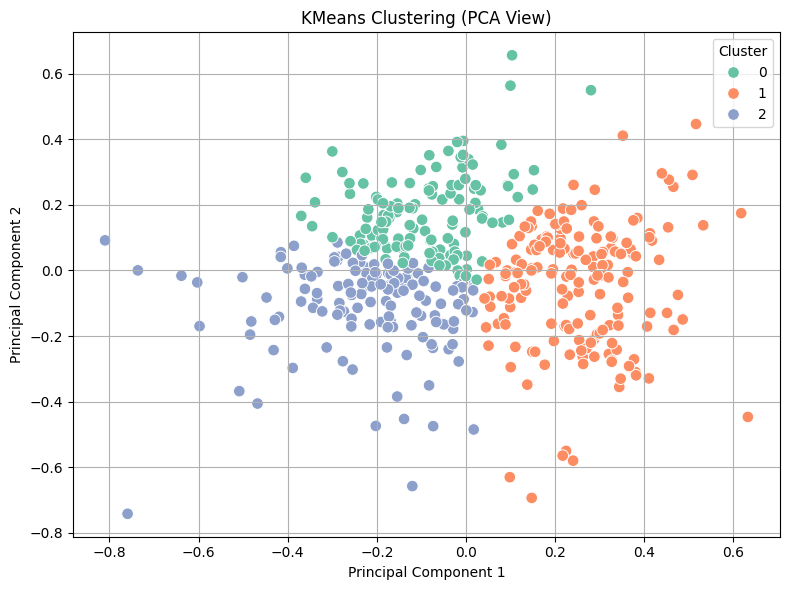

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.decomposition import PCA

# Use T+N as an example for full preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming `features` is your original dataset with 6 numeric features
features = data.drop(["Channel", "Region"], axis=1)

# T + N + PCA
data_log = np.log1p(features)
scaler = MinMaxScaler()
log_normalized = pd.DataFrame(scaler.fit_transform(data_log), columns=features.columns)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
data_pca = pd.DataFrame(pca.fit_transform(log_normalized), columns=["PC1", "PC2"])

# === KMeans ===
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans_labels = kmeans.fit_predict(log_normalized)

# === Hierarchical ===
hc = AgglomerativeClustering(n_clusters=3)
hc_labels = hc.fit_predict(log_normalized)

# === Mean Shift ===
ms = MeanShift()
ms_labels = ms.fit_predict(log_normalized)

# Plotting function
def plot_clusters(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_2d["PC1"], y=data_2d["PC2"], hue=labels, palette="Set2", s=70)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all three
plot_clusters(data_pca, kmeans_labels, "KMeans Clustering (PCA View)")



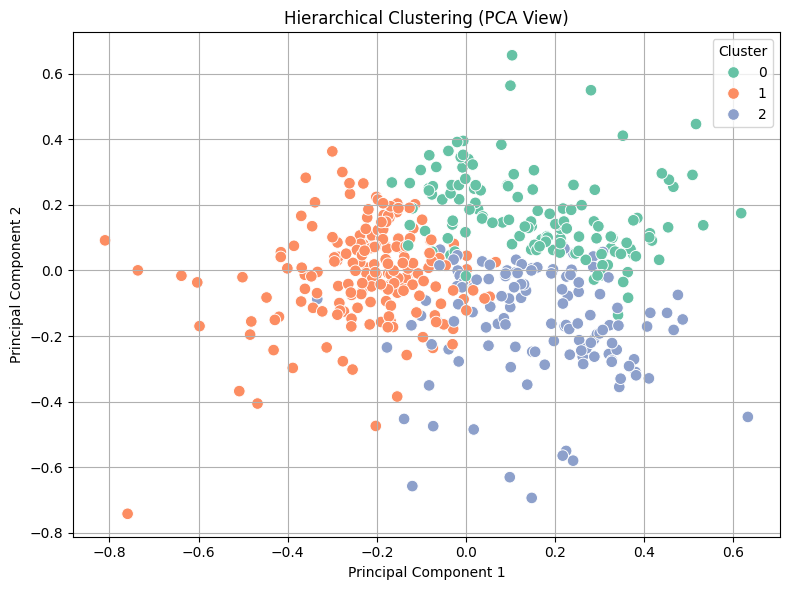

In [28]:
plot_clusters(data_pca, hc_labels, "Hierarchical Clustering (PCA View)")


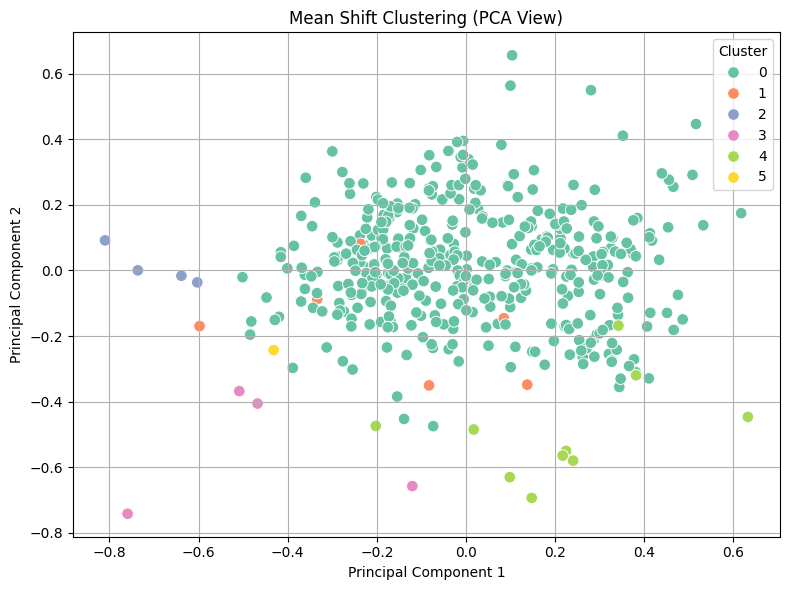

In [29]:

plot_clusters(data_pca, ms_labels, "Mean Shift Clustering (PCA View)")